In [10]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [11]:
df =pd.read_sql_table('microwave', 'sqlite:///dissertation.db') 

In [12]:
df_copy = df.copy()

In [13]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
# prepare data for clustering
df_half['weekofyear']=df_half.index.week
df_half['day_categ']=df_half.index.day_name()
df_half['day_num']=df_half.index.weekday
#df_half['day']=df_half.index.day
df_half['hour']=df_half.index.hour


# prepare day_type --> weekday, weekend, holiday
df_half['day_type'] = df_half['day_num'].apply(lambda x: 'weekday' if x <5 else 'weekend')
df_half.loc[(df_half.index >= '2019-12-24 00:00:00') & (df_half.index < '2019-12-26 00:00:00'), 'day_type']='holiday'
df_half.loc[(df_half.index >= '2020-01-01 00:00:00') & (df_half.index < '2020-01-02 00:00:00'), 'day_type']='holiday'

# prepare morning, afternoon, and night 
df_half['time_of_day'] =df_half['hour'].apply(lambda x: 'morning' if (x>=7) & (x<= 12) else ('afternoon' if (x>12) & (x<=18) else 'night'))

# lockdown
df_half.loc[(df_half.weekofyear >=12) & (df_half.weekofyear <24), 'day_type'] = 'holiday'


df_half['hour']=df_half.index.strftime('%H')

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [8]:
# subset 80% of dataset for train and test, 20% for future input  
subset = 6451
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [175]:
# split into train and test sets
train_size = int(len(train_test) * 0.5)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

3225 3226


In [167]:
# manipulate data to x,and y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [176]:
look_back=96
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [109]:
# add extra variables day_type and time of the day

# extract the train variables for same length
df_train_var=df_half[['day_categ','time_of_day','day_type']][:len(trainX)]
# get dummies
df_dum_train=pd.get_dummies(df_train_var)

# extract the test variables for same length
df_test_var=df_half[['day_categ','time_of_day','day_type']][len(trainX):len(trainX)+len(testX)]
# get dummies
df_dum_test=pd.get_dummies(df_test_var)

# extract the validation variables for same length
df_simu_var=df_half[['day_categ','time_of_day','day_type']][len(trainX)+len(testX):len(trainX)+len(testX)+len(simuX)]
# get dummies
df_dum_simu=pd.get_dummies(df_simu_var)
df_dum_simu['day_type_weekday']=0
df_dum_simu['day_type_weekend']=0

In [110]:
#to np
np_train=np.array(df_dum_train)

#to np
np_test=np.array(df_dum_test)

#to np
np_simu=np.array(df_dum_simu)

In [111]:
#concatenate trainX, testX, validX with variables, respectively
trainX_ok = np.concatenate((trainX, np_train),axis=1)
testX_ok = np.concatenate((testX, np_test),axis=1)
simuX_ok = np.concatenate((simuX, np_simu),axis=1)

In [112]:
# standarise variables
from sklearn.preprocessing import normalize
#normal = preprocessing.Normalizer()
trainX_scaled =normalize(trainX_ok)
testX_scaled = normalize(testX_ok)
simuX_scaled = normalize(simuX_ok)


In [177]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(200, input_dim=look_back, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history = model.fit(trainX, trainY, epochs=250, batch_size=10, verbose=2)

Epoch 1/250
 - 1s - loss: 848.8121 - mse: 848.8121 - mae: 13.1278 - mape: 6066350592.0000
Epoch 2/250
 - 1s - loss: 719.5845 - mse: 719.5845 - mae: 10.8174 - mape: 4422599168.0000
Epoch 3/250
 - 1s - loss: 640.0997 - mse: 640.0999 - mae: 9.9139 - mape: 3822267648.0000
Epoch 4/250
 - 1s - loss: 531.9615 - mse: 531.9614 - mae: 9.0796 - mape: 3530848256.0000
Epoch 5/250
 - 1s - loss: 436.5371 - mse: 436.5372 - mae: 8.0577 - mape: 3030818816.0000
Epoch 6/250
 - 1s - loss: 365.9094 - mse: 365.9093 - mae: 7.3896 - mape: 2745217280.0000
Epoch 7/250
 - 1s - loss: 268.3536 - mse: 268.3537 - mae: 6.4475 - mape: 2596865792.0000
Epoch 8/250
 - 1s - loss: 278.2465 - mse: 278.2465 - mae: 6.2922 - mape: 2379915776.0000
Epoch 9/250
 - 1s - loss: 238.6453 - mse: 238.6454 - mae: 6.0600 - mape: 2416381952.0000
Epoch 10/250
 - 1s - loss: 172.1287 - mse: 172.1287 - mae: 5.1574 - mape: 2046205184.0000
Epoch 11/250
 - 1s - loss: 159.2446 - mse: 159.2446 - mae: 4.9648 - mape: 2078859136.0000
Epoch 12/250
 - 1

Epoch 95/250
 - 1s - loss: 15.4250 - mse: 15.4250 - mae: 1.2534 - mape: 319695744.0000
Epoch 96/250
 - 1s - loss: 17.4381 - mse: 17.4381 - mae: 1.3150 - mape: 325300736.0000
Epoch 97/250
 - 1s - loss: 14.3323 - mse: 14.3323 - mae: 1.2381 - mape: 317538464.0000
Epoch 98/250
 - 1s - loss: 18.6766 - mse: 18.6766 - mae: 1.4146 - mape: 381983616.0000
Epoch 99/250
 - 1s - loss: 14.7136 - mse: 14.7136 - mae: 1.2604 - mape: 353219840.0000
Epoch 100/250
 - 1s - loss: 14.0860 - mse: 14.0860 - mae: 1.2368 - mape: 321912768.0000
Epoch 101/250
 - 1s - loss: 16.1672 - mse: 16.1672 - mae: 1.2828 - mape: 312510240.0000
Epoch 102/250
 - 1s - loss: 18.0595 - mse: 18.0595 - mae: 1.3563 - mape: 329994112.0000
Epoch 103/250
 - 1s - loss: 19.0105 - mse: 19.0105 - mae: 1.4403 - mape: 347044096.0000
Epoch 104/250
 - 1s - loss: 24.4372 - mse: 24.4372 - mae: 1.5677 - mape: 388693984.0000
Epoch 105/250
 - 1s - loss: 17.5204 - mse: 17.5204 - mae: 1.3568 - mape: 366205056.0000
Epoch 106/250
 - 1s - loss: 16.8065 -

Epoch 189/250
 - 1s - loss: 6.8111 - mse: 6.8111 - mae: 0.7674 - mape: 184375296.0000
Epoch 190/250
 - 1s - loss: 7.1419 - mse: 7.1419 - mae: 0.7490 - mape: 157895424.0000
Epoch 191/250
 - 1s - loss: 7.7712 - mse: 7.7712 - mae: 0.8013 - mape: 177093968.0000
Epoch 192/250
 - 1s - loss: 8.6894 - mse: 8.6894 - mae: 0.8792 - mape: 194548208.0000
Epoch 193/250
 - 1s - loss: 8.0710 - mse: 8.0710 - mae: 0.8772 - mape: 210945136.0000
Epoch 194/250
 - 1s - loss: 10.3246 - mse: 10.3246 - mae: 0.9317 - mape: 203526704.0000
Epoch 195/250
 - 1s - loss: 10.7777 - mse: 10.7777 - mae: 0.9223 - mape: 183371472.0000
Epoch 196/250
 - 1s - loss: 13.5149 - mse: 13.5149 - mae: 1.0506 - mape: 237065504.0000
Epoch 197/250
 - 1s - loss: 14.5928 - mse: 14.5928 - mae: 1.0373 - mape: 215540912.0000
Epoch 198/250
 - 1s - loss: 14.2685 - mse: 14.2685 - mae: 1.0347 - mape: 201531104.0000
Epoch 199/250
 - 1s - loss: 11.3687 - mse: 11.3687 - mae: 0.9599 - mape: 190902048.0000
Epoch 200/250
 - 1s - loss: 7.1539 - mse: 

In [178]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])

3129/3129 [==============================] - 0s 40us/step
Train MSE:  5.669088363647461 MAE:  0.7425777316093445
Test MSE:  280.18701171875 MAE:  3.009960412979126


### link: https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

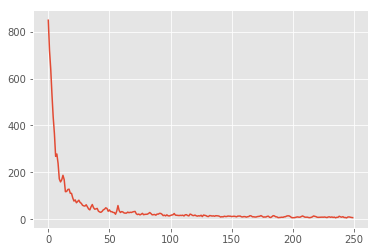

In [179]:
plt.plot(history.history['loss'])

In [180]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [181]:
print(nextPredict,df_simu[0:1].values)

[[0.17072219]] [[0.]]


In [182]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.1099719706571416

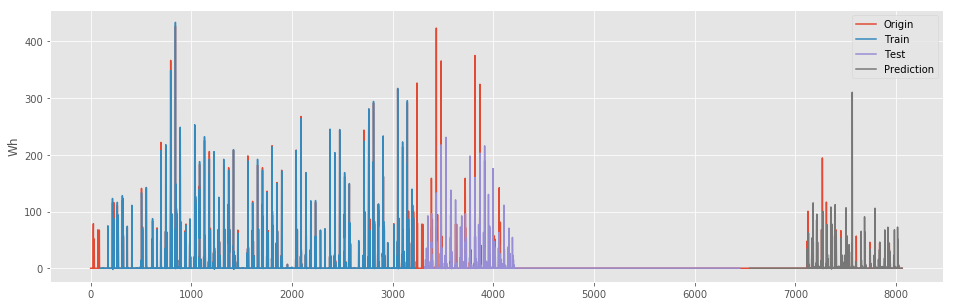

In [183]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [184]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

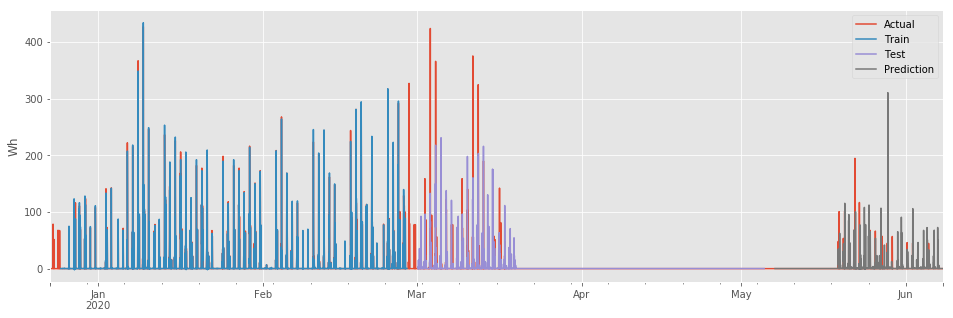

In [185]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

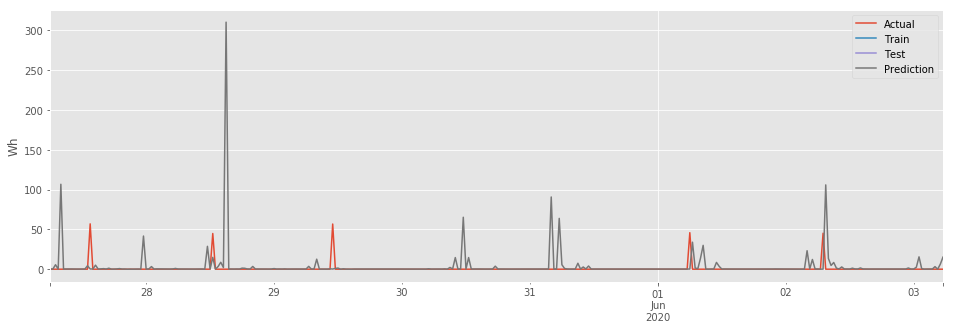

In [186]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

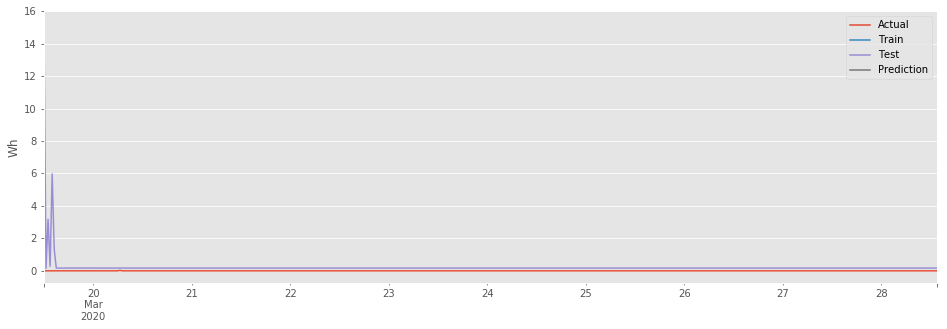

In [187]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

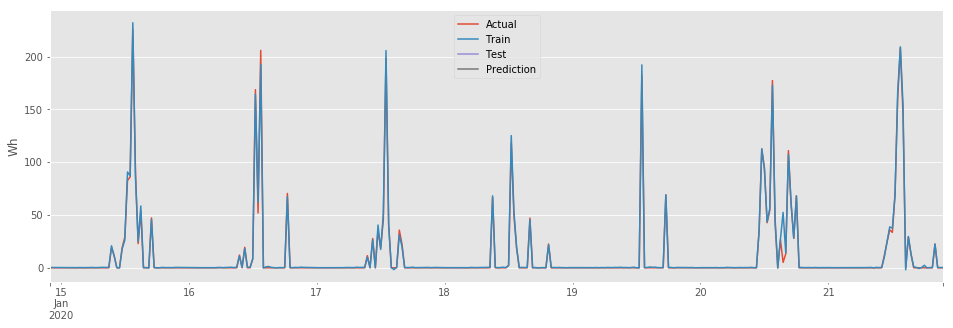

In [188]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [189]:
# save the model 
model.save('microwave_ann.h5')

In [9]:
# with lockdown
mad_mean_ratio = 3.009*3226/df_half['Half_Wh'][6451-3226:6451].sum()
mad_mean_ratio

1.4155979451481397